Week 2: tests in numpyro

In [10]:
import numpy as np
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# pick the true mu and sigma
true_mu = 3.0
true_sigma = 1.5

In [3]:
# generate synthetic data
np.random.seed(0)
data = np.random.normal(loc=true_mu, scale=true_sigma, size=100)

In [4]:
# define model
def model(data):
    mu = numpyro.sample("mu", dist.Normal(0, 10))  # loose prior
    sigma = numpyro.sample("sigma", dist.HalfNormal(5.0))  # loose prior
    # repeat len(data) times, taking independent samples from data
    with numpyro.plate("data", len(data)):
        numpyro.sample("obs", dist.Normal(mu, sigma), obs=data)

In [5]:
# prepare and run MCMC
#
# DEFINITIONS:
# ---------------
# NUTS (No-U-Turn Sampler)
#   - Monte Carlo sampling method used to explore complex posterior distributions efficiently
# Markov Chain Monte Carlo
#   - Family of algorithms for sampling complex probability distributions
#   - Instead of computing the p(data), which is hard, let's just sample a bunch of times 
#     from the posterior to estimate the parameters
#   - A Markov chain is a sequence of states (param values here) where each one depends only
#     the previous one. MCMC uses this to explore param value possibilites but starting
#     somewhere in the param space and "walking around," accepting or discarding new param
#     values based on likeliness. Eventually, we settle on values.

nuts_kernel = NUTS(model)  # create kernel 
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)  # wrap with MCMC sampler
mcmc.run(jax.random.PRNGKey(0), data=jnp.array(data))  # run
mcmc.print_summary()

sample: 100%|██████████| 1500/1500 [00:02<00:00, 637.27it/s, 7 steps of size 7.39e-01. acc. prob=0.94] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      3.09      0.15      3.09      2.83      3.33    750.98      1.00
     sigma      1.58      0.12      1.57      1.40      1.77    543.73      1.00

Number of divergences: 0


In [6]:
# get posterior samples
posterior_samples = mcmc.get_samples()
mu_samples = posterior_samples["mu"]
sigma_samples = posterior_samples["sigma"]

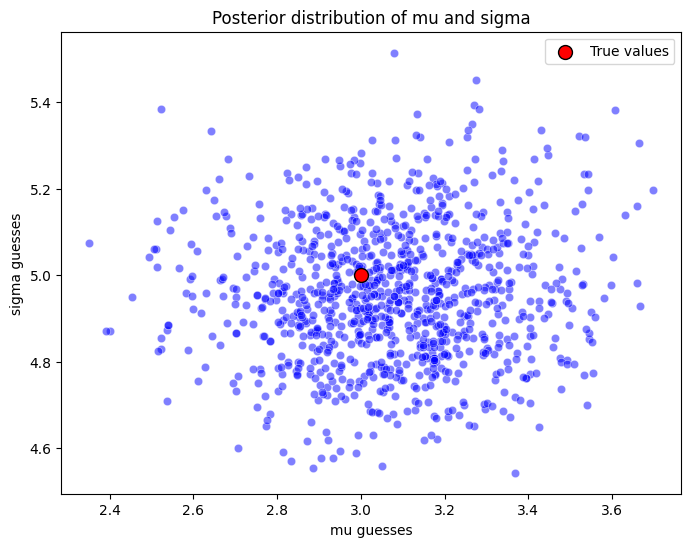

In [31]:
# plots

plt.figure(figsize=(8, 6))
sns.scatterplot(x=mu_samples, y=sigma_samples, color='blue', alpha=0.5)
plt.scatter(true_mu, true_sigma, color='red', label="True values", s=100, edgecolor='black')
plt.title("Posterior distribution of mu and sigma")
plt.xlabel("mu guesses")
plt.ylabel("sigma guesses")
plt.legend()
plt.show()

sample: 100%|██████████| 1500/1500 [00:02<00:00, 569.53it/s, 3 steps of size 8.25e-01. acc. prob=0.93] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      2.81      0.24      2.81      2.40      3.21    795.66      1.00
     sigma      5.33      0.17      5.32      5.07      5.60    572.13      1.00

Number of divergences: 0


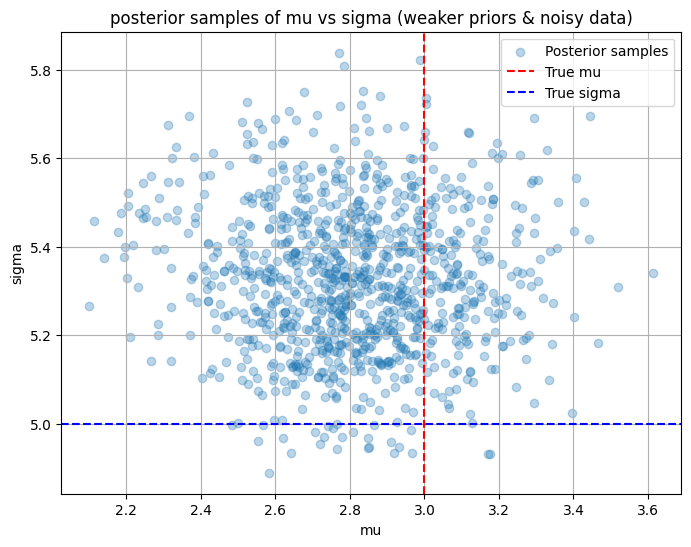

In [32]:
# example with more spread out (noisy) data and weaker priors


# true values
true_mu = 3.0
true_sigma = 5.0  # more spread out

# generate synthetic data
data = np.random.normal(loc=true_mu, scale=true_sigma, size=500)  # larger, more varied dataset

# model with weak priors
def model(data):
    mu = numpyro.sample("mu", dist.Normal(0, 100))  # weak prior
    sigma = numpyro.sample("sigma", dist.HalfNormal(50.0))  # weak, flexible prior
    with numpyro.plate("data", len(data)):
        numpyro.sample("obs", dist.Normal(mu, sigma), obs=data)

# run MCMC
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
mcmc.run(jax.random.PRNGKey(1), data=jnp.array(data))
posterior_samples = mcmc.get_samples()
mcmc.print_summary()

# plot mu vs sigma samples
mu_samples = posterior_samples["mu"]
sigma_samples = posterior_samples["sigma"]

plt.figure(figsize=(8, 6))
plt.scatter(mu_samples, sigma_samples, alpha=0.3, label="Posterior samples")
plt.axvline(true_mu, color='red', linestyle='--', label='True mu')
plt.axhline(true_sigma, color='blue', linestyle='--', label='True sigma')
plt.xlabel("mu")
plt.ylabel("sigma")
plt.title("posterior samples of mu vs sigma (weaker priors & noisy data)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# we see above that since our dataset is so large and the spread is wide, having weak priors
# didn't help our posterior much (respective of our scale)

In [ ]:
# Similar noisy dataset with strict, innacruate priors.
# This is helping me visualize how priors can have a large affect on the posterior dist

# if are priors are:
#   - weak but realistic, and the data is not noisy, our posterior accuracy will good
#   - strong but realistic, and the data is not noisy, our posterior accuracy will be accurate (priors help here)
#   - strong but wrong, and the data is phenomonal, our posterior will be inaccurate

sample: 100%|██████████| 1500/1500 [00:02<00:00, 605.79it/s, 3 steps of size 9.02e-01. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      3.06      0.22      3.06      2.70      3.41    724.86      1.00
     sigma      4.80      0.16      4.79      4.54      5.05    792.58      1.00

Number of divergences: 0


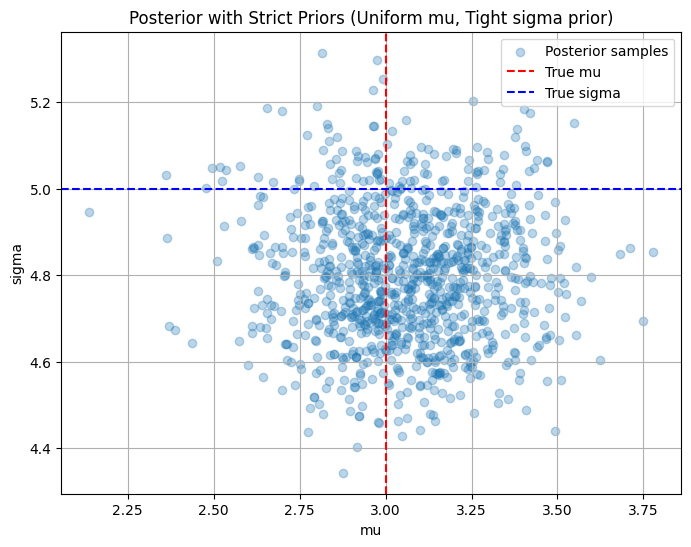

In [29]:
# generate synthetic data
data = np.random.normal(loc=true_mu, scale=true_sigma, size=500)  # larger, more varied dataset

# stricter priors
def strict_priors_model(data):
    mu = numpyro.sample("mu", dist.Uniform(0.0, 5.0))  # strict uniform prior
    sigma = numpyro.sample("sigma", dist.HalfNormal(1.0))  # underestimates possible noise
    with numpyro.plate("data", len(data)):
        numpyro.sample("obs", dist.Normal(mu, sigma), obs=data)

# run MCMC
nuts_kernel = NUTS(strict_priors_model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
mcmc.run(jax.random.PRNGKey(2), data=jnp.array(data))
posterior_samples = mcmc.get_samples()
mcmc.print_summary()

# plot
mu_samples = posterior_samples["mu"]
sigma_samples = posterior_samples["sigma"]

# sigma should be pretty innacruate
plt.figure(figsize=(8, 6))
plt.scatter(mu_samples, sigma_samples, alpha=0.3, label="Posterior samples")
plt.axvline(true_mu, color='red', linestyle='--', label='True mu')
plt.axhline(true_sigma, color='blue', linestyle='--', label='True sigma')
plt.xlabel("mu")
plt.ylabel("sigma")
plt.title("Posterior with Strict Priors (Uniform mu, Tight sigma prior)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# we see above that sigma is pretty innacruate because our prior was strict and innacruate (respective of our scale)